In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

pd.get_option("max_info_columns")

100

In [2]:
pd.set_option("display.max_info_columns", 300) 

gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   4835 non-null   object  
 1   LSOA11NM   4835 non-null   object  
 2   MSOA11CD   4835 non-null   object  
 3   MSOA11NM   4835 non-null   object  
 4   LAD11CD    4835 non-null   object  
 5   LAD11NM    4835 non-null   object  
 6   RGN11CD    4835 non-null   object  
 7   RGN11NM    4835 non-null   object  
 8   USUALRES   4835 non-null   int64   
 9   HHOLDRES   4835 non-null   int64   
 10  COMESTRES  4835 non-null   int64   
 11  POPDEN     4835 non-null   float64 
 12  HHOLDS     4835 non-null   int64   
 13  AVHHOLDSZ  4835 non-null   float64 
 14  geometry   4835 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 566.7+ KB


In [3]:
df = pd.read_csv('https://data.london.gov.uk/download/lsoa-atlas/0193f884-2ccd-49c2-968e-28aa3b1c480d/lsoa-data.csv',
                 encoding= 'unicode_escape', na_values=[':'], low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 277 columns):
 #   Column                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                            --------------  -----  
 0   Lower Super Output Area                                                                                           4835 non-null   object 
 1   Names                                                                                                             4835 non-null   object 
 2   Mid-year Population Estimates;All Ages;2001                                                                       4835 non-null   float64
 3   Mid-year Population Estimates;All Ages;2002                                                                       4835 non-null   float64
 4   Mid-year Population Estimates

In [5]:
df = df[['Lower Super Output Area','Economic Activity;Economically active: Total;2011','Economic Activity;Economically inactive: Total;2011',
         'Economic Activity;Employment Rate;2011','Economic Activity;Unemployment Rate;2011','Household Income, 2011/12;Mean Annual Household Income estimate (£)',
         'Public Transport Accessibility Levels (2014);Average Score;','Public Transport Accessibility Levels (2014);% 4-6 (good access)','Public Transport Accessibility Levels (2014);% 0-1 (poor access)']]
df.head()

Lower Super Output Area  Economic Activity;Economically active: Total;2011  \
0               E01000907                                              719.0   
1               E01000908                                              833.0   
2               E01000909                                              886.0   
3               E01000912                                              848.0   
4               E01000913                                              963.0   

   Economic Activity;Economically inactive: Total;2011  \
0                                              343.0     
1                                              351.0     
2                                              367.0     
3                                              387.0     
4                                              323.0     

   Economic Activity;Employment Rate;2011  \
0                                    58.6   
1                                    62.3   
2                                    65.7   
3                                    58.8   
4                                    71.8   

   Economic Activity;Unemployment Rate;2011  \
0                                       9.9   
1                                       8.0   
2                                       4.9   
3                                       8.8   
4                                       2.1   

   Household Income, 2011/12;Mean Annual Household Income estimate (£)  \
0                                            39985.0                     
1                                            42394.0                     
2                                            77370.0                     
3                                            41737.0                     
4                                            96649.0                     

   Public Transport Accessibility Levels (2014);Average Score;  \
0                                                4.6             
1                                                2.9             
2                                                3.3             
3                                                4.6             
4                                                2.8             

   Public Transport Accessibility Levels (2014);% 4-6 (good access)  \
0                                               45.9                  
1                                                0.0                  
2                                                0.0                  
3                                               41.6                  
4                                                0.5                  

   Public Transport Accessibility Levels (2014);% 0-1 (poor access)  
0                                                0.0                 
1                                               33.7                 
2                                                0.0                 
3                                                0.0                 
4                                               27.8

In [6]:
df.columns = ['lsoa','Eco_Active','Eco_inact','Employment','Unemployment','Income_Mean','PTAL_Mean','PTAL_good','PTAL_bad']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lsoa          4835 non-null   object 
 1   Eco_Active    4835 non-null   float64
 2   Eco_inact     4835 non-null   float64
 3   Employment    4835 non-null   float64
 4   Unemployment  4835 non-null   float64
 5   Income_Mean   4835 non-null   float64
 6   PTAL_Mean     4835 non-null   float64
 7   PTAL_good     4835 non-null   float64
 8   PTAL_bad      4835 non-null   float64
dtypes: float64(8), object(1)
memory usage: 340.2+ KB


In [7]:
pd.isnull(df).sum() > 0

lsoa            True
Eco_Active      True
Eco_inact       True
Employment      True
Unemployment    True
Income_Mean     True
PTAL_Mean       True
PTAL_good       True
PTAL_bad        True
dtype: bool

In [8]:
print(df[df['Eco_Active'].isnull()])

     lsoa  Eco_Active  Eco_inact  Employment  Unemployment  Income_Mean  \
4835  NaN         NaN        NaN         NaN           NaN          NaN   
4836  NaN         NaN        NaN         NaN           NaN          NaN   

      PTAL_Mean  PTAL_good  PTAL_bad  
4835        NaN        NaN       NaN  
4836        NaN        NaN       NaN  


In [9]:
print(df[df['PTAL_Mean'].isnull()])

     lsoa  Eco_Active  Eco_inact  Employment  Unemployment  Income_Mean  \
4835  NaN         NaN        NaN         NaN           NaN          NaN   
4836  NaN         NaN        NaN         NaN           NaN          NaN   

      PTAL_Mean  PTAL_good  PTAL_bad  
4835        NaN        NaN       NaN  
4836        NaN        NaN       NaN  


In [10]:
print(df.shape)

df = df.dropna()

print(df.shape)

(4837, 9)
(4835, 9)


In [11]:
ppd = pd.merge(gdf, df, left_on='LSOA11CD', right_on='lsoa', how='inner').reset_index()
ppd.shape
ppd.sample(3)

index   LSOA11CD         LSOA11NM   MSOA11CD        MSOA11NM    LAD11CD  \
284     284  E01000289      Barnet 004D  E02000027      Barnet 004  E09000003   
1229   1229  E01001248      Ealing 035A  E02000272      Ealing 035  E09000009   
4507   4507  E01004621  Wandsworth 019D  E02000941  Wandsworth 019  E09000032   

         LAD11NM    RGN11CD RGN11NM  USUALRES  ...  \
284       Barnet  E12000007  London      1817  ...   
1229      Ealing  E12000007  London      1592  ...   
4507  Wandsworth  E12000007  London      1686  ...   

                                               geometry       lsoa  \
284   POLYGON ((525152.955 195793.030, 525222.890 19...  E01000289   
1229  POLYGON ((516026.341 179370.256, 516216.830 17...  E01001248   
4507  POLYGON ((527037.000 174953.578, 527087.698 17...  E01004621   

      Eco_Active  Eco_inact  Employment Unemployment Income_Mean  PTAL_Mean  \
284        806.0      458.0        50.8         12.4     27820.0        2.3   
1229       865.0      307.0        66.9          5.7     46979.0        2.8   
4507      1038.0      281.0        74.5          3.0     70039.0        2.6   

      PTAL_good  PTAL_bad  
284         0.1      60.9  
1229        0.0      25.7  
4507       10.6      71.0  

[3 rows x 25 columns]

In [12]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [13]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

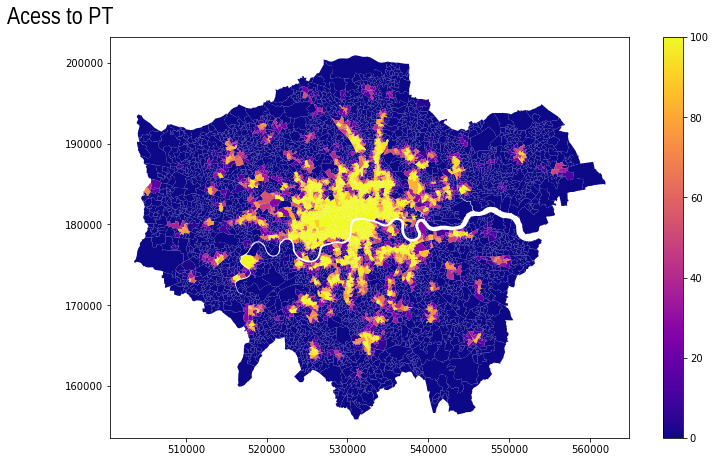

In [14]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='PTAL_good', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Acess to PT", x=0.025, size=24, **tfont);

In [15]:
ppd = ppd[['LSOA11NM','LSOA11CD','geometry','Eco_Active','Eco_inact','Employment','Unemployment','Income_Mean','PTAL_Mean','PTAL_good','PTAL_bad']].copy()
ppd.head()

LSOA11NM   LSOA11CD  \
0        City of London 001A  E01000001   
1        City of London 001B  E01000002   
2        City of London 001C  E01000003   
3        City of London 001E  E01000005   
4  Barking and Dagenham 016A  E01000006   

                                            geometry  Eco_Active  Eco_inact  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...       964.0      257.0   
1  POLYGON ((532746.813 181786.891, 532671.688 18...       926.0      270.0   
2  POLYGON ((532135.145 182198.119, 532158.250 18...       822.0      280.0   
3  POLYGON ((533807.946 180767.770, 533649.063 18...       530.0      243.0   
4  POLYGON ((545122.049 184314.931, 545271.917 18...       874.0      377.0   

   Employment  Unemployment  Income_Mean  PTAL_Mean  PTAL_good  PTAL_bad  
0        74.9           3.5      74846.0        8.0      100.0       0.0  
1        74.8           1.7      73325.0        8.0      100.0       0.0  
2        67.2           4.7      44130.0        7.3      100.0       0.0  
3        58.9           8.7      30781.0        8.0      100.0       0.0  
4        58.6           9.5      46141.0        6.4       89.4       0.0

In [16]:
to_cluster = ppd[['LSOA11CD','Eco_Active','Eco_inact','Employment','Unemployment','Income_Mean','PTAL_Mean','PTAL_good','PTAL_bad']].set_index('LSOA11CD').copy()
to_cluster.head()

Eco_Active  Eco_inact  Employment  Unemployment  Income_Mean  \
LSOA11CD                                                                  
E01000001       964.0      257.0        74.9           3.5      74846.0   
E01000002       926.0      270.0        74.8           1.7      73325.0   
E01000003       822.0      280.0        67.2           4.7      44130.0   
E01000005       530.0      243.0        58.9           8.7      30781.0   
E01000006       874.0      377.0        58.6           9.5      46141.0   

           PTAL_Mean  PTAL_good  PTAL_bad  
LSOA11CD                                   
E01000001        8.0      100.0       0.0  
E01000002        8.0      100.0       0.0  
E01000003        7.3      100.0       0.0  
E01000005        8.0      100.0       0.0  
E01000006        6.4       89.4       0.0

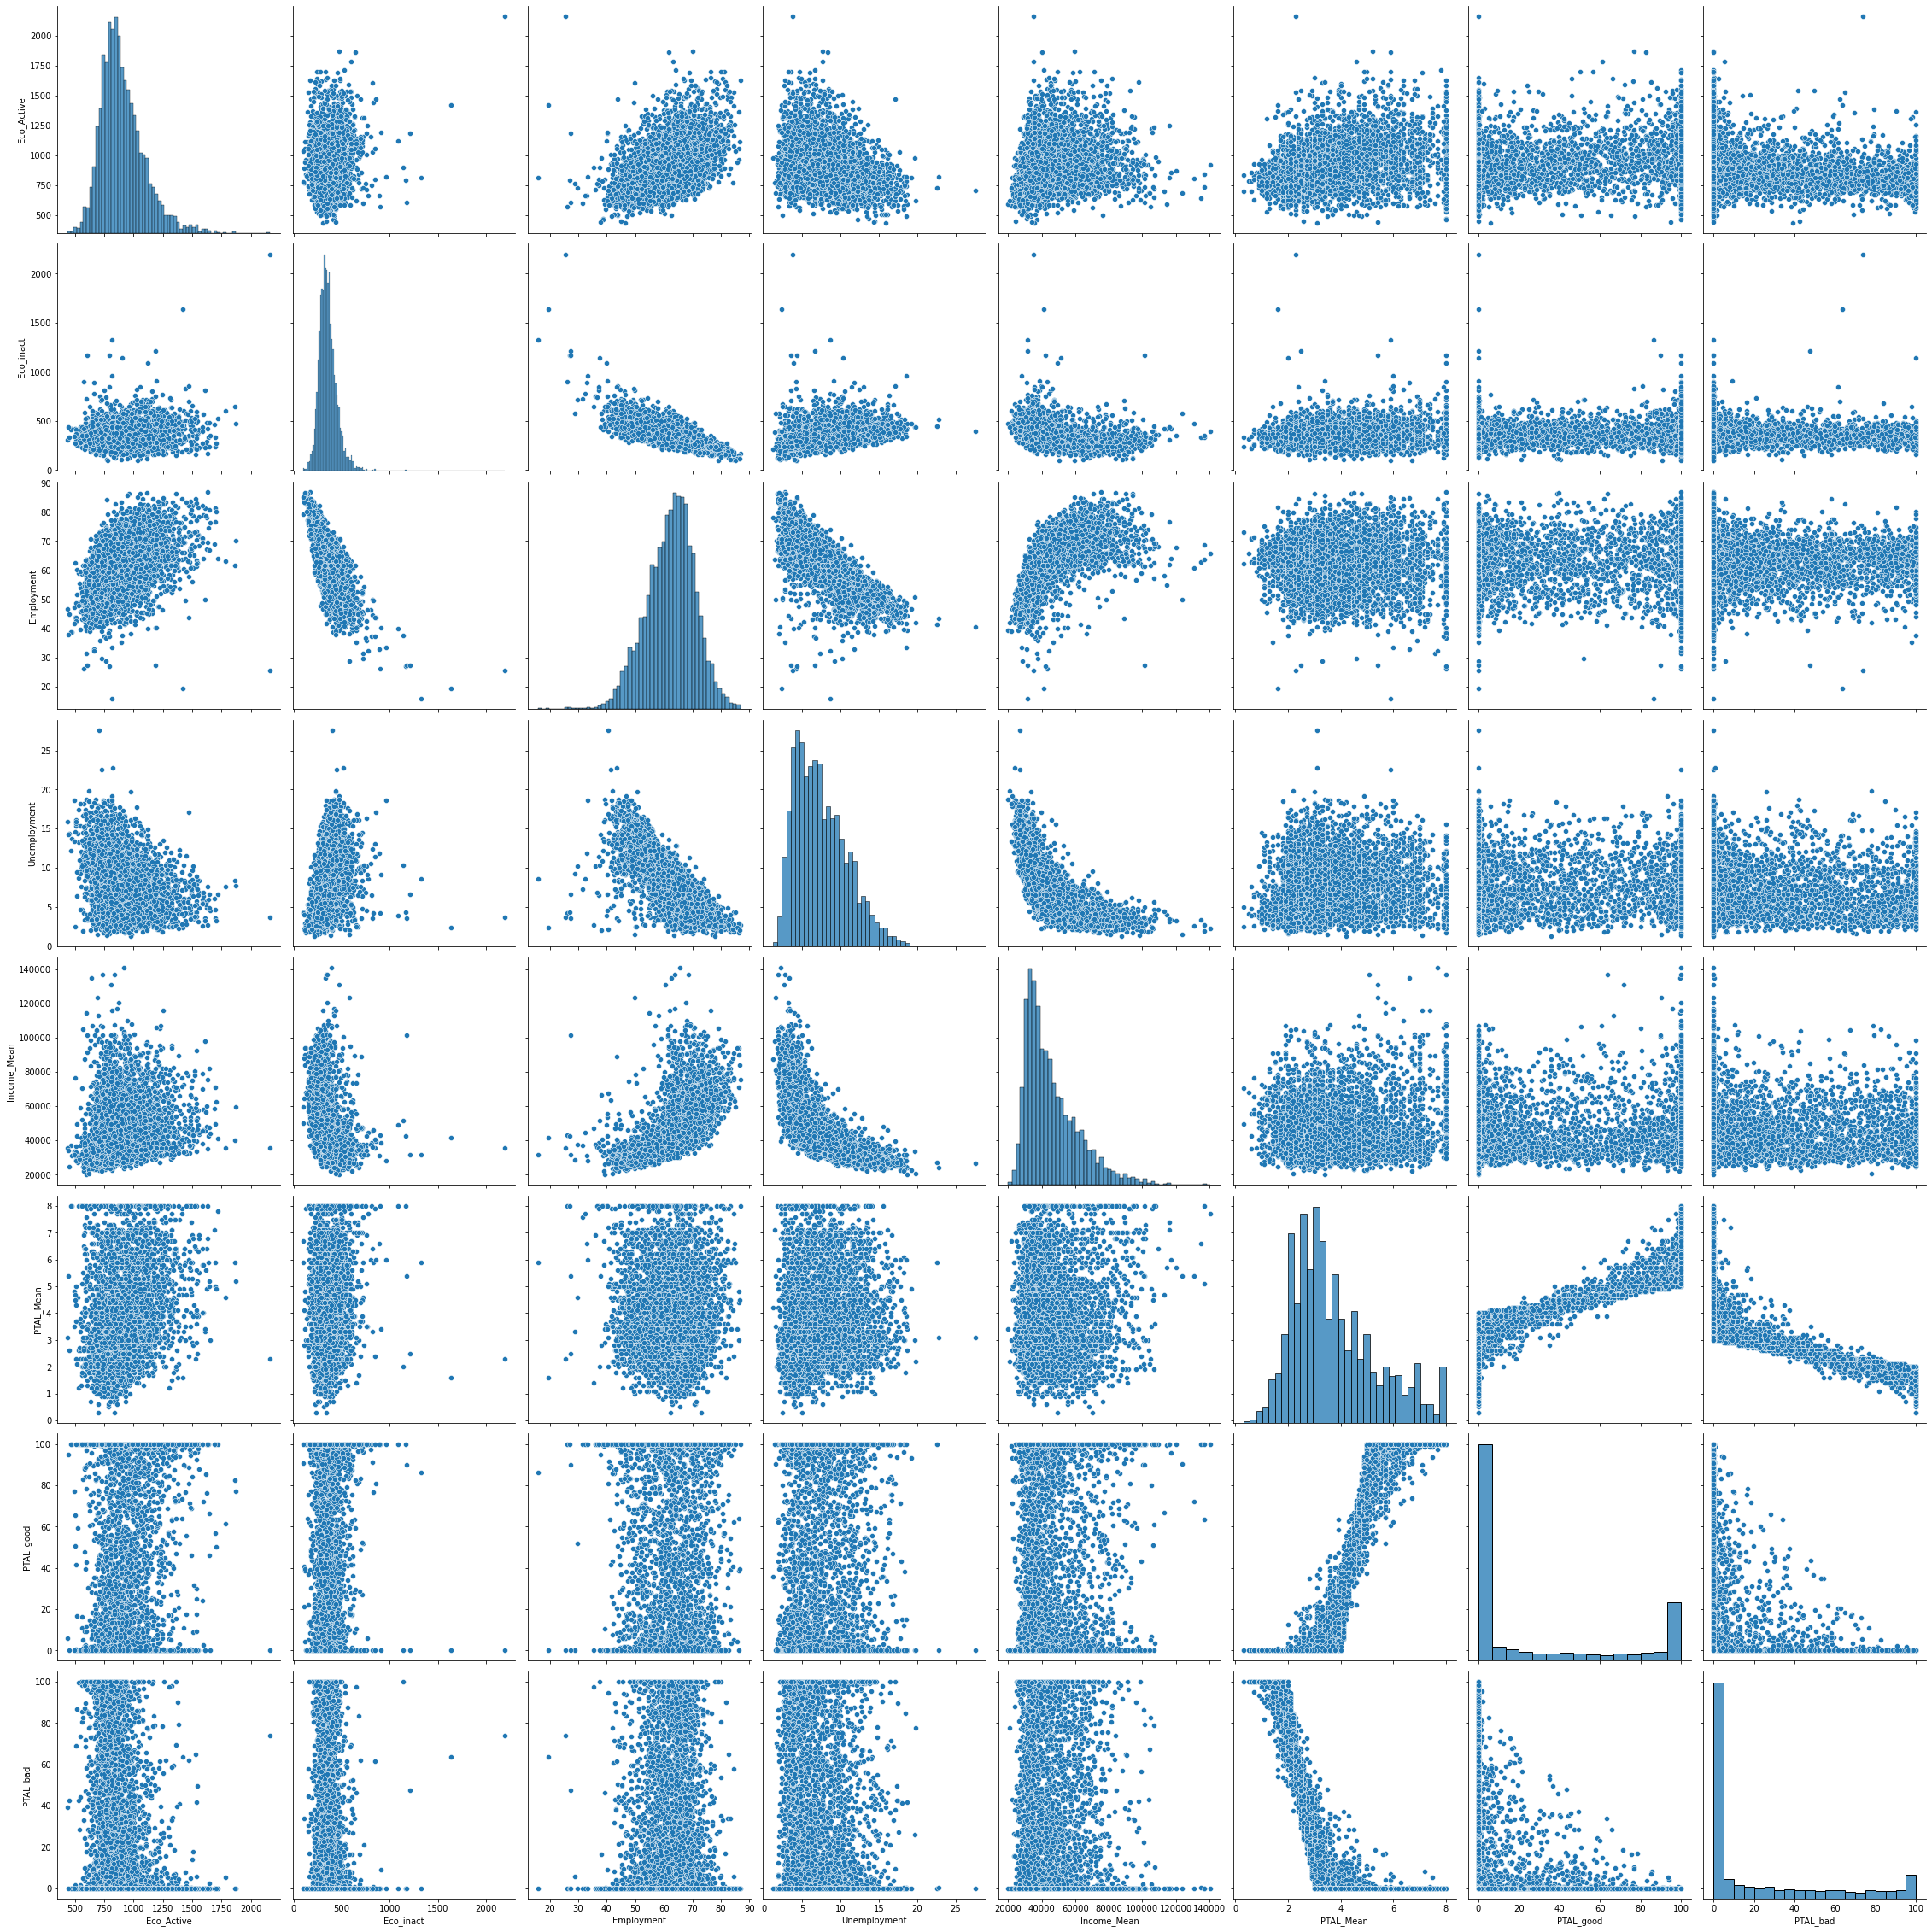

In [17]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [18]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

Eco_Active  Eco_inact  Employment  Unemployment  Income_Mean  \
LSOA11CD                                                                  
E01033492    0.901603  -3.215372    2.671514     -1.796942     1.383409   
E01033135   -0.725839  -4.831820    2.911638     -2.207857     1.888098   
E01003119    1.611612  -0.807646    1.053332     -0.070332     0.239250   
E01000503    0.607100   1.070702   -0.451826      0.348333    -0.583107   
E01004509    2.896598  -0.892455    2.274543     -1.499340     1.137569   

           PTAL_Mean  PTAL_good  PTAL_bad  
LSOA11CD                                   
E01033492   0.932094   1.235456 -1.001057  
E01033135   0.399895   1.037642 -1.001057  
E01003119   1.334512   1.260446 -1.001057  
E01000503  -0.935878  -0.934447  1.131631  
E01004509   0.833750   1.108452 -1.001057

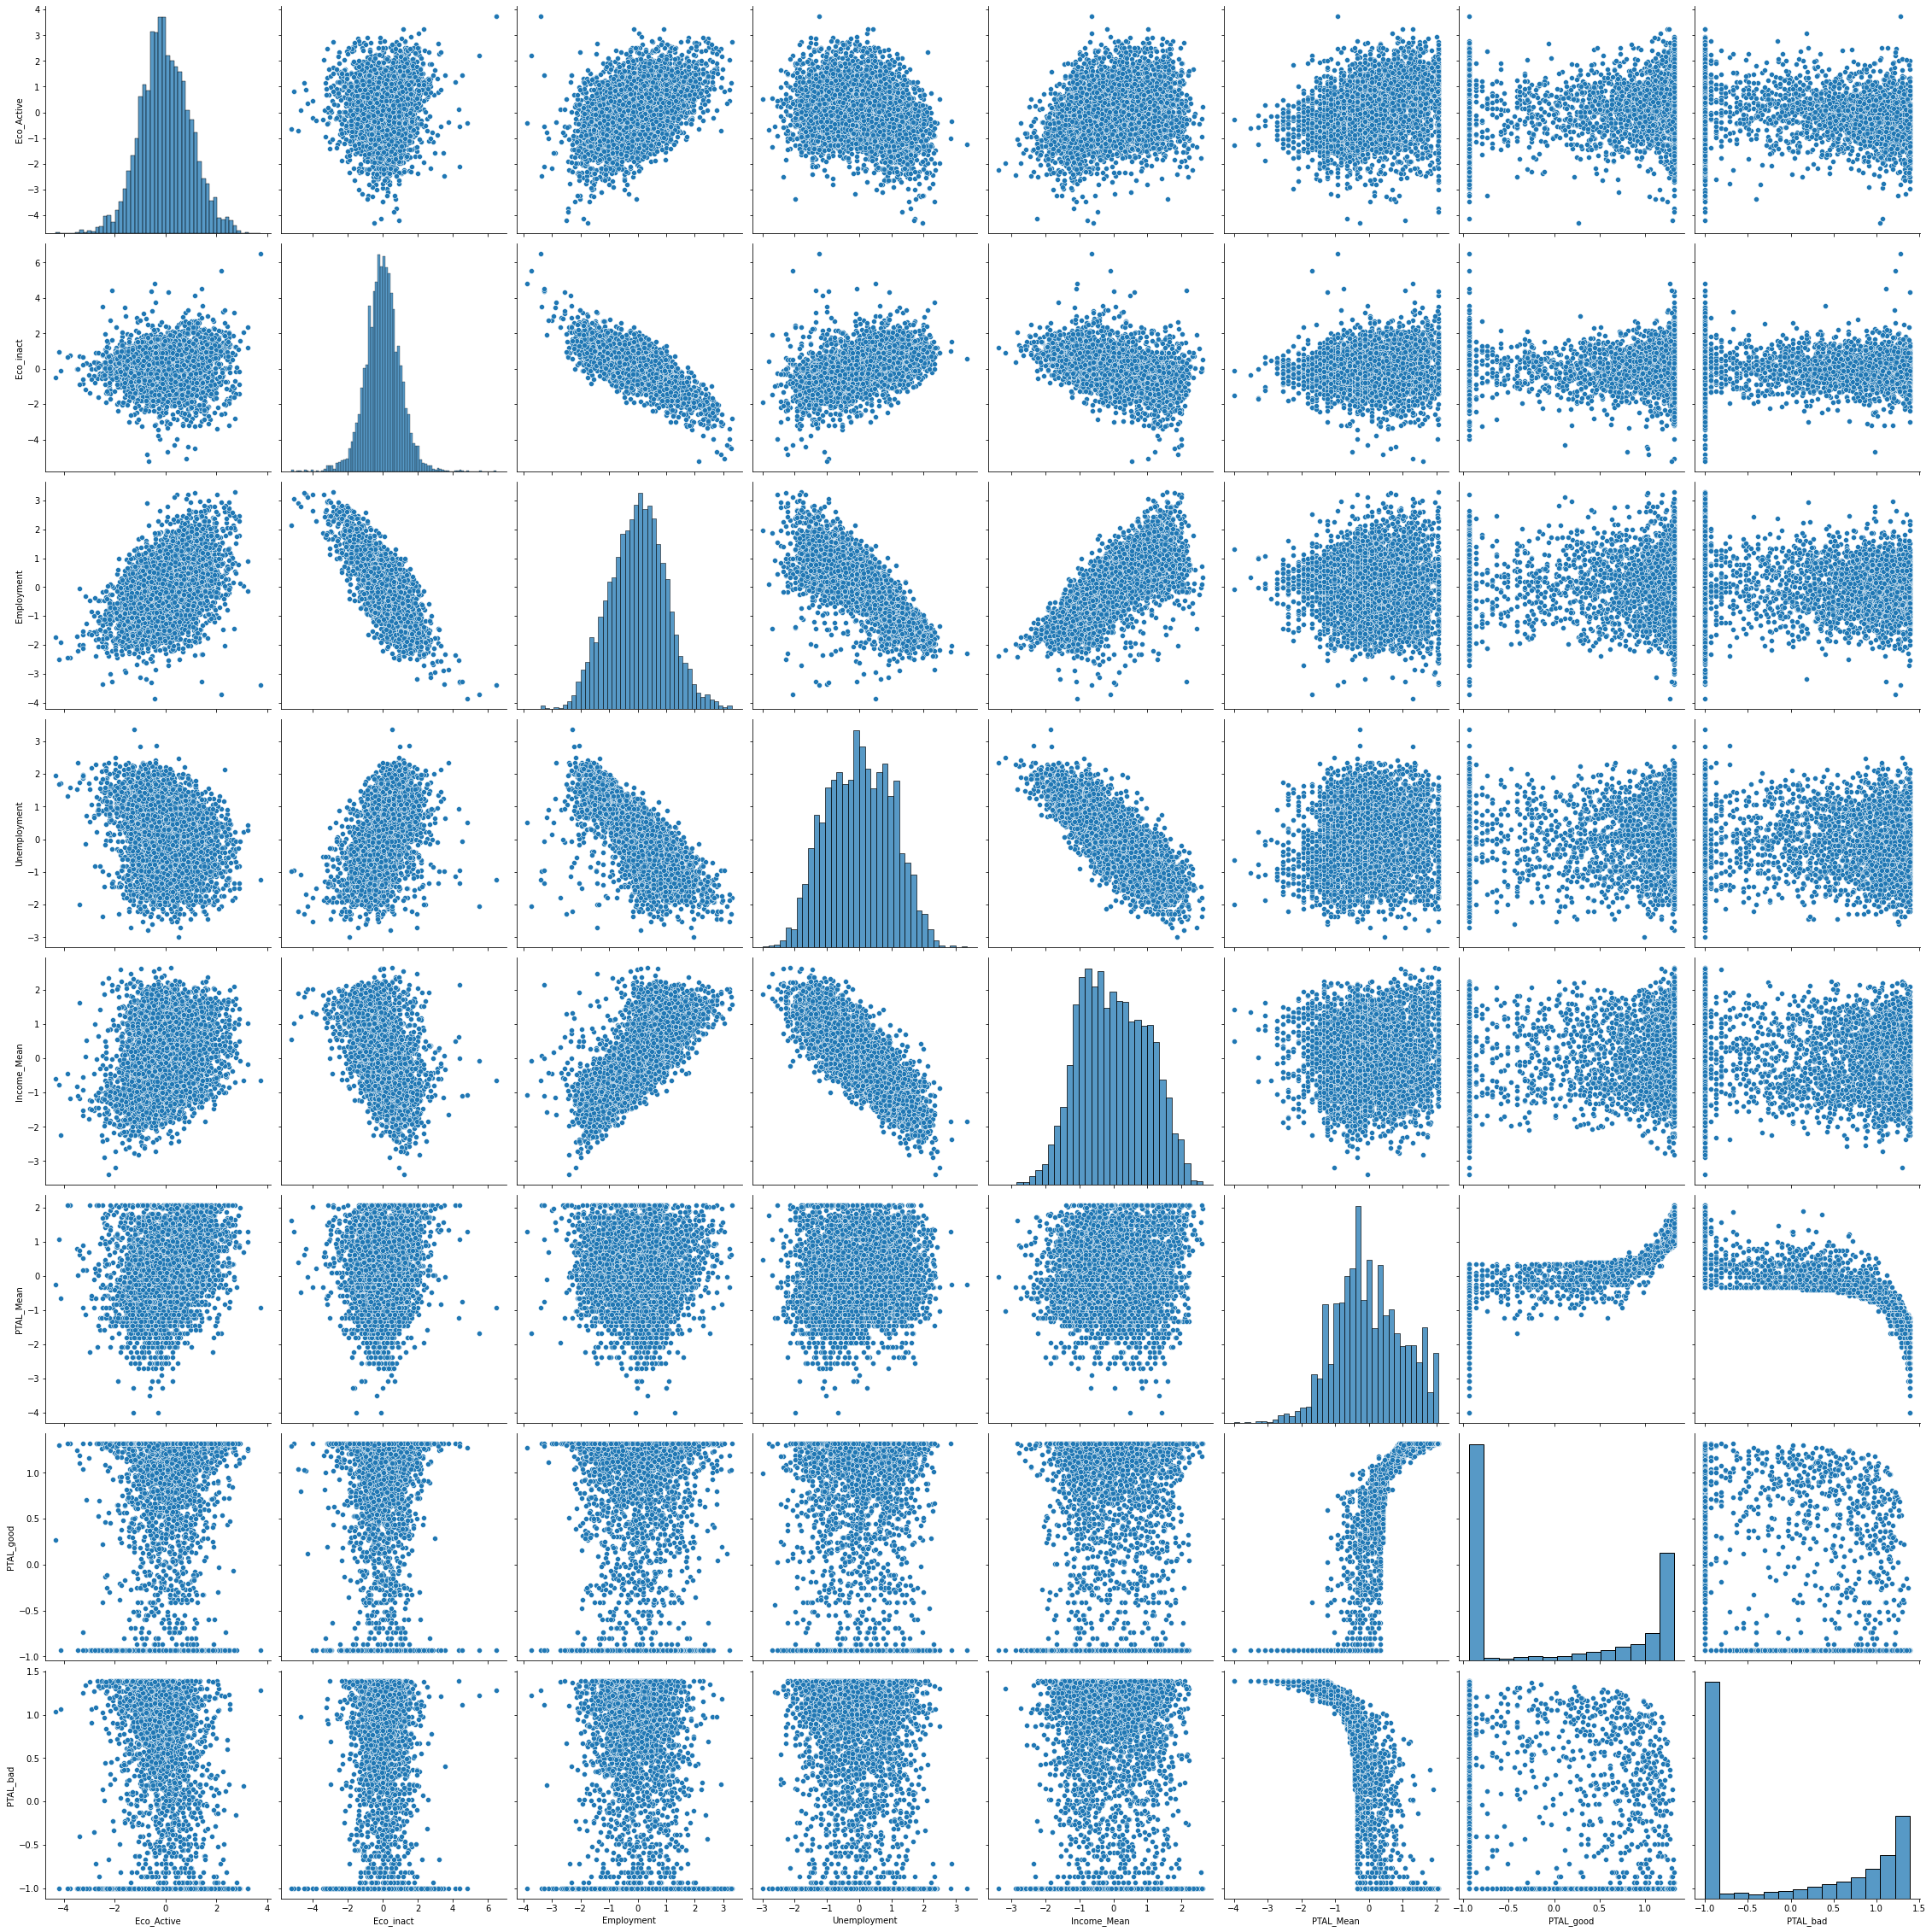

In [19]:
plot_norm = sns.pairplot(normed,height = 4)

In [20]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.39244927 0.34463573 0.11260176 0.07516302 0.0390845  0.0193067
 0.01375484 0.00300418]


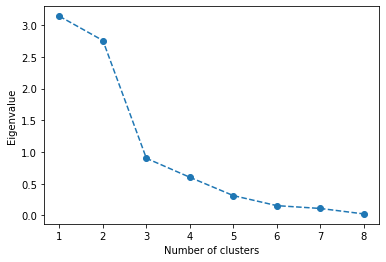

In [21]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [22]:
pca = PCA(n_components = 3)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.39244927 0.34463573 0.11260176]


In [23]:
list_var = normed.columns.tolist()
print(list_var)

['Eco_Active', 'Eco_inact', 'Employment', 'Unemployment', 'Income_Mean', 'PTAL_Mean', 'PTAL_good', 'PTAL_bad']


In [24]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

Eco_Active  Eco_inact  Employment  Unemployment  Income_Mean  PTAL_Mean  \
0    0.213574  -0.418368    0.539295     -0.497377     0.490565  -0.000800   
1   -0.274736  -0.101735   -0.011947     -0.089288    -0.034700  -0.572801   
2    0.791218   0.535711    0.017614     -0.087643     0.005651  -0.153991   

   PTAL_good  PTAL_bad  
0   0.019513  0.009781  
1  -0.539161  0.534841  
2  -0.138516  0.189905

In [25]:
score_pca = pca.transform(normed)
score_pca

array([[ 2.85699425, -2.38630334, -0.7876295 ],
       [ 3.29481509, -2.24302501, -0.73876967],
       [ 1.01760162, -2.05278837, -1.29597713],
       ...,
       [-1.3259048 ,  0.33533916,  0.33103113],
       [-0.32879693,  1.78940625,  0.34203408],
       [ 1.59254492, -1.64495264, -0.9601608 ]])

In [26]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[3.14024366 2.75765621 0.90100047]


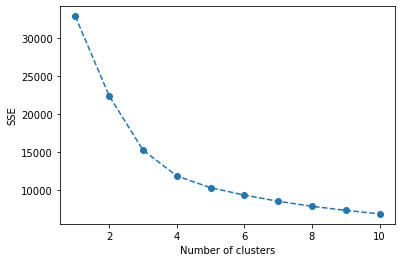

In [27]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [42]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=3, random_state=1)

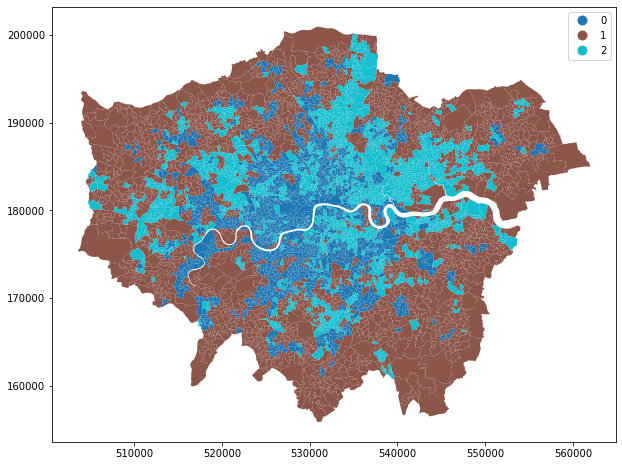

In [43]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [30]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-3: ] = ['Component1','Component2','Component3']

In [46]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third'})

In [32]:
ppd_kpca.head()

LSOA11NM   LSOA11CD  \
0        City of London 001A  E01000001   
1        City of London 001B  E01000002   
2        City of London 001C  E01000003   
3        City of London 001E  E01000005   
4  Barking and Dagenham 016A  E01000006   

                                            geometry  Eco_Active  Eco_inact  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...       964.0      257.0   
1  POLYGON ((532746.813 181786.891, 532671.688 18...       926.0      270.0   
2  POLYGON ((532135.145 182198.119, 532158.250 18...       822.0      280.0   
3  POLYGON ((533807.946 180767.770, 533649.063 18...       530.0      243.0   
4  POLYGON ((545122.049 184314.931, 545271.917 18...       874.0      377.0   

   Employment  Unemployment  Income_Mean  PTAL_Mean  PTAL_good  PTAL_bad  \
0        74.9           3.5      74846.0        8.0      100.0       0.0   
1        74.8           1.7      73325.0        8.0      100.0       0.0   
2        67.2           4.7      44130.0        7.3      100.0       0.0   
3        58.9           8.7      30781.0        8.0      100.0       0.0   
4        58.6           9.5      46141.0        6.4       89.4       0.0   

   Kmeans_Cluster  Component1  Component2  Component3 Segement  
0               0    2.856994   -2.386303   -0.787629    First  
1               0    3.294815   -2.243025   -0.738770    First  
2               0    1.017602   -2.052788   -1.295977    First  
3               2   -1.164699   -1.463476   -3.849197    Third  
4               2   -0.629062   -2.179093   -0.520096    Third

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


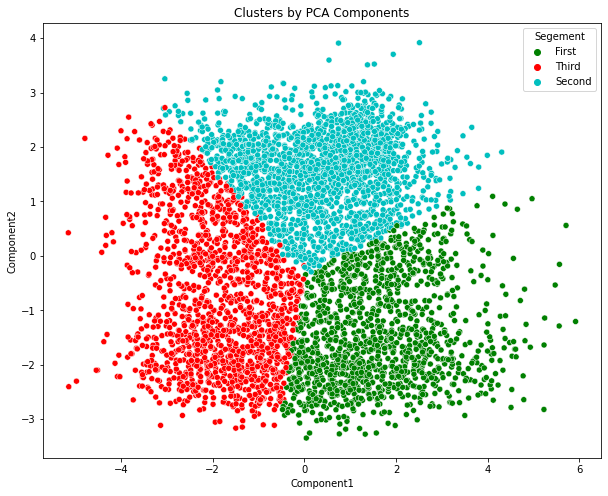

In [47]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r','c'])
plt.title('Clusters by PCA Components')
plt.show()

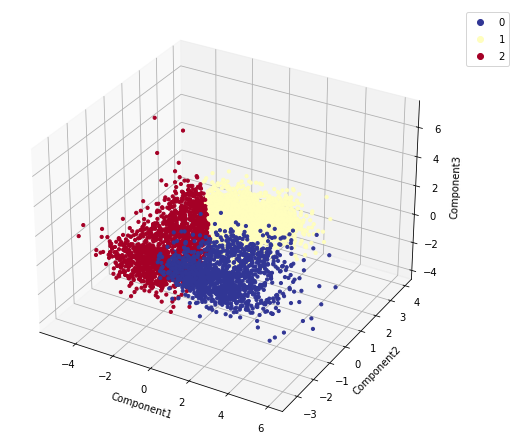

In [34]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdYlBu_r", 256).as_hex())

x = ppd_kpca['Component1']
y = ppd_kpca['Component2']
z = ppd_kpca['Component3']

# plot
sc = ax.scatter(x, y, z, s=40, c=ppd_kpca['Kmeans_Cluster'], marker='.', cmap=cmap, alpha=1)
ax.set_xlabel('Component1')
ax.set_ylabel('Component2')
ax.set_zlabel('Component3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

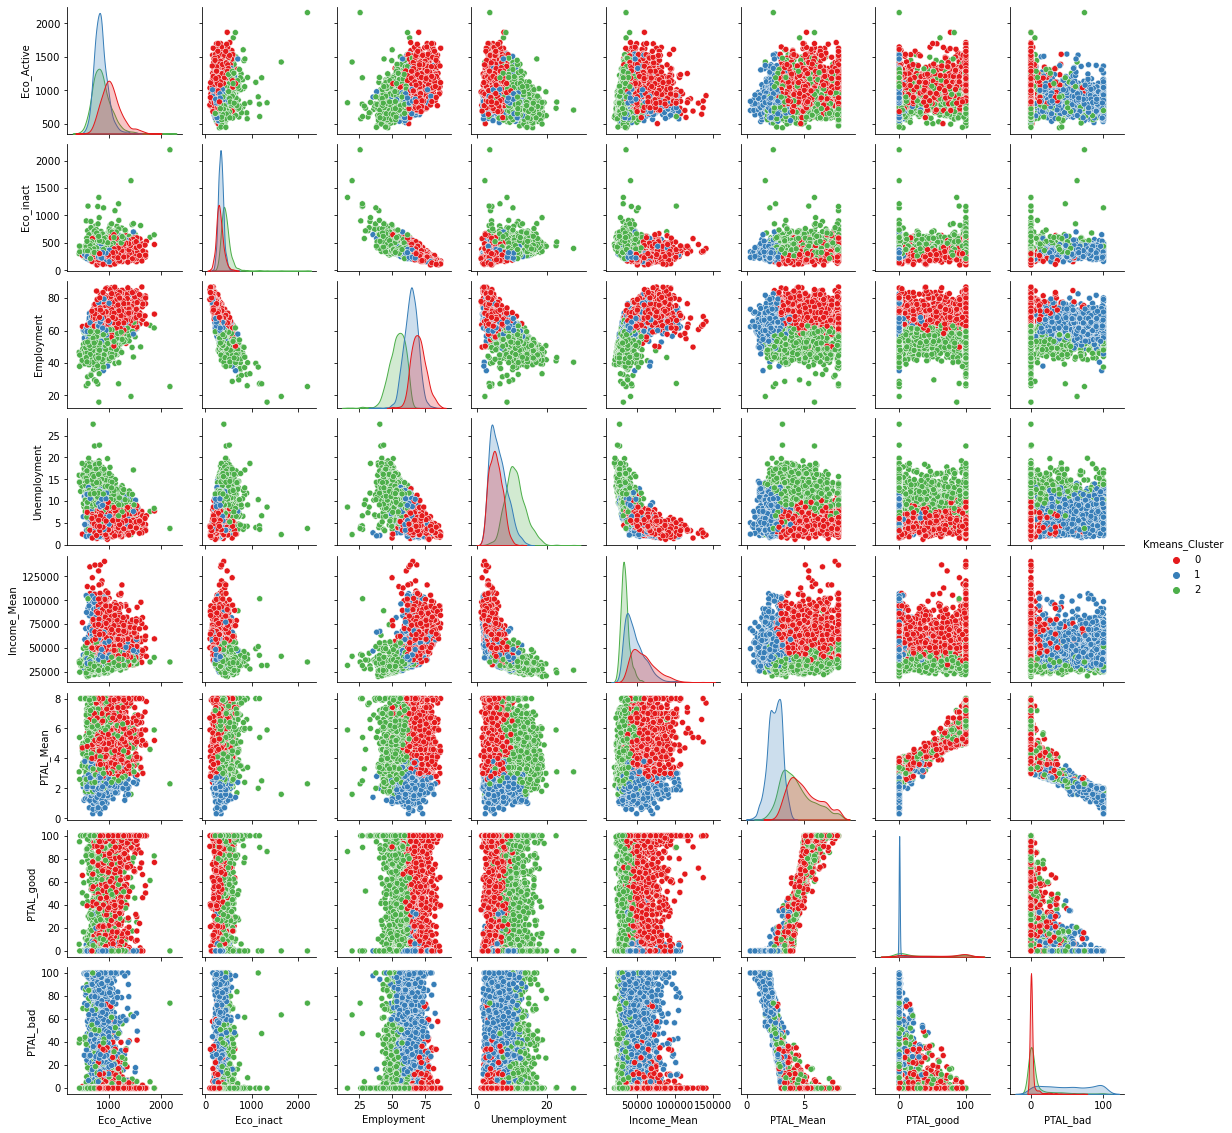

In [44]:
plot_norm = sns.pairplot(ppd,hue = 'Kmeans_Cluster',height = 2,palette = 'Set1')